In [4]:
"""
Copyright (C) 2014 John Evans

This example code illustrates how to access and visualize an LP DAAC MOD13C2
v6 HDF-EOS2 Grid file in Python.

If you have any questions, suggestions, or comments on this example, please use
the HDF-EOS Forum (http://hdfeos.org/forums).  If you would like to see an
example of any other NASA HDF/HDF-EOS data product that is not listed in the
HDF-EOS Comprehensive Examples page (http://hdfeos.org/zoo), feel free to
contact us at eoshelp@hdfgroup.org or post it at the HDF-EOS Forum
(http://hdfeos.org/forums).

Usage:  save this script and run

    $python MOD13C2.A2007001.006.2015161222701.hdf.py

The HDF file must be in your current working directory.

Tested under: Python 2.7.14 :: Anaconda custom (64-bit)
Last updated: 2018-04-13
"""

import os
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pyhdf.SD import SD, SDC
import cartopy.crs as ccrs
import xarray as xr
import ipdb
import datetime
import glob
import os
import pandas as pd



In [5]:

# FILE_NAME = '/media/ck/Elements/global/MODIS_LST/MOD11C1.A2021216.006.2021221195429.hdf'
# #FILE_NAME = 'MOD13C2.A2007001.006.2015161222701.hdf'

# # Identify the data field.
# DATAFIELD_NAME = 'CMG 0.05 Deg Daily LST'

# hdf = SD(FILE_NAME, SDC.READ)

# # Read dataset.
# data2D = hdf.select(DATAFIELD_NAME)
# data = data2D[:,:].astype(np.double)

# # Read attributes.
# attrs = data2D.attributes(full=1)
# lna=attrs["long_name"]
# long_name = lna[0]
# vra=attrs["valid_range"]
# valid_range = vra[0]
# aoa=attrs["add_offset"]
# add_offset = aoa[0]
# fva=attrs["_FillValue"]
# _FillValue = fva[0]
# sfa=attrs["scale_factor"]
# scale_factor = sfa[0]        
# ua=attrs["units"]
# units = ua[0]

# # Handle fill value.
# invalid = data == _FillValue
# invalid = np.logical_or(invalid, data < valid_range[0])
# invalid = np.logical_or(invalid, data > valid_range[1])
# data[invalid] = np.nan

# # Apply scale factor and offset.
# data = (data - add_offset) / scale_factor 
# data = np.ma.masked_array(data, np.isnan(data))
        
# # Normally we would use the grid metadata to reconstruct the grid, but
# # the grid metadata is incorrect in this case, specifically the upper left
# # and lower right coordinates of the grid.  We'll construct the grid
# # manually, taking into account the fact that we're going to subset the
# # data by a factor of 10 (the grid size is 3600 x 7200).
# x = np.linspace(-180, 180, 7200)
# y = np.linspace(90, -90, 3600)
# lon, lat = np.meshgrid(x, y)

In [75]:
getMODISflag(np.array(121.))

array(0)

In [9]:
def read_modis_monthly(FILE_NAME, dnames, save):#dnames=None, save=False):
    
    def getMODISflag(flags):
        bla = flags.astype(int)
        mask = []

        for b, i in zip(np.nditer(bla), range(bla.size)):
            bb = '{0:008b}'.format(int(b))

            take = 0

            if len(bb) == 8:
                mandat = bb[0:2]
                quali = bb[2:4]
                emierr = bb[4:6]
                lsterr = bb[6:8]

                if (mandat in ['00','01']) & (lsterr in ['00']):      
                    take =1
            #print(bb)
            mask.append(take)
        mask = np.reshape(np.array(mask), bla.shape)

        return mask
    
    
    # Identify the data field.
    
#     fields = ['CMG 0.05 Deg Monthly NDVI']
#     DATAFIELD_NAME = 'CMG 0.05 Deg Monthly NDVI'
    print('Doing ',FILE_NAME)

    out = FILE_NAME.replace('.hdf', '.nc')
    out = out.replace('raw', 'nc_new')
    if (save) & os.path.isfile(out):
        print('File exists, return')
        return
    try:
        hdf = SD(FILE_NAME, SDC.READ)
    except:
        print('read error with file ', FILE_NAME, 'continue')
        return
    
    if dnames is None:
        dnames = hdf.datasets().keys()
    
    ds = xr.Dataset()
    
    # Normally we would use the grid metadata to reconstruct the grid, but
    # the grid metadata is incorrect in this case, specifically the upper left
    # and lower right coordinates of the grid.  We'll construct the grid
    # manually, taking into account the fact that we're going to subset the
    # data by a factor of 10 (the grid size is 3600 x 7200).
    lon = np.linspace(-180, 180, 7200)
    lat = np.linspace(90, -90, 3600)
    #lon, lat = np.meshgrid(x, y)
    
    split_date = FILE_NAME.split('.')[1]
    year = split_date[1:5]
    
    date = datetime.datetime(int(year), 1, 1) + pd.Timedelta(str(int(split_date[5:8]) - 1)+' days')
    
    #ipdb.set_trace()
    
    for DATAFIELD_NAME in dnames:

        # Read dataset.
        data2D = hdf.select(DATAFIELD_NAME)
        data = data2D[:,:].astype(np.float)

        # Read attributes.
        attrs = data2D.attributes(full=1)
        lna=attrs["long_name"]
        long_name = lna[0]
        vra=attrs["valid_range"]
        valid_range = vra[0]
        try:
            aoa=attrs["add_offset"]
            add_offset = aoa[0]
        except:
            add_offset = 0
            pass
        fva=attrs["_FillValue"]
        _FillValue = fva[0]
        try:
            sfa=attrs["scale_factor"]
            scale_factor = sfa[0]
        except:
            pass
        #ua=attrs["units"]
        #units = ua[0]

        # Handle fill value.
        invalid = data == _FillValue
        invalid = np.logical_or(invalid, data < valid_range[0])
        invalid = np.logical_or(invalid, data > valid_range[1])
        data[invalid] = np.nan

        # Apply scale factor and offset.
        if 'LST' in DATAFIELD_NAME:
           # ipdb.set_trace()
            data = data  * scale_factor 
            data = (data * 100).astype(int)
        if ('angl' in DATAFIELD_NAME) | ('Emis' in DATAFIELD_NAME):
            data = data * scale_factor + add_offset
            data = ((data<=40) & (data>=-40)).astype(int)
        #ipdb.set_trace()
        #data = np.ma.masked_array(data, np.isnan(data))
        
        da = xr.DataArray(data[None, ...], coords={'time': np.array([date]),
                                             'lat': lat,
                                             'lon': lon},
                      dims=['time', 'lat', 'lon'])  # .isel(time=0)
        
        ds[DATAFIELD_NAME] = da
        
    ql_mask = getMODISflag(ds['QC_Day'])
    
    ds['LST_Day_CMG'].values[(ds['Day_view_angl'].values!=1) | (ql_mask!=1)] = -999
    ds = ds.drop(['Day_view_angl'])
    ds = ds.drop(['QC_Day'])
    if save:
        comp = dict(zlib=True, complevel=5)
        encoding = {var: comp for var in ds.data_vars}
        
        #ipdb.set_trace()
        ds.to_netcdf(path=out, mode='w', encoding=encoding, format='NETCDF4')
        return
        
    return ds

In [10]:
FILE_NAME = '/media/ck/LStorage/MODIS_LST/aqua/raw_v6/MYD11C1.A2021294.006.2021298191543.hdf'
test = read_modis_monthly(FILE_NAME, dnames=['LST_Day_CMG','Day_view_angl','QC_Day'], save=False)   #['CMG 0.05 Deg Monthly NDVI']

Doing  /media/ck/LStorage/MODIS_LST/aqua/raw_v6/MYD11C1.A2021294.006.2021298191543.hdf


In [8]:
test.sel(lat=slice(25,3))

<xarray.Dataset>
Dimensions:      (lat: 440, lon: 7200, time: 1)
Coordinates:
  * time         (time) datetime64[ns] 2021-10-21
  * lat          (lat) float64 24.98 24.93 24.88 24.83 ... 3.126 3.076 3.026
  * lon          (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
Data variables:
    LST_Day_CMG  (time, lat, lon) int64 -999 -999 -999 -999 ... -999 -999 -999
    QC_Day       (time, lat, lon) float64 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0

In [13]:
test['LST_Day_CMG'].min()

<xarray.DataArray 'LST_Day_CMG' ()>
array(-999)

In [11]:
flags_test = test['LST_Day_CMG'].isel(time=0)#.sel(lat=slice(25,3), lon=slice(-15,15))

In [72]:
out = getMODISflag(flags_test.values)

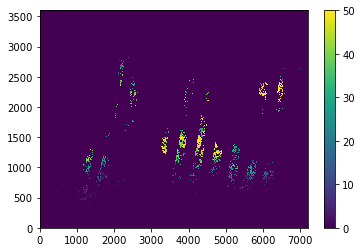

In [15]:
plt.pcolormesh(flags_test/100-273.15, vmin=0, vmax=50)
plt.colorbar()

In [45]:
np.unique(flags_test.values[np.isfinite(flags_test.values)])

array([  1.,   2.,   3.,   5.,   8.,   9.,  13.,  16.,  17.,  21.,  24.,
        25.,  29.,  32.,  33.,  40.,  41.,  45.,  65.,  69.,  73.,  77.,
        81.,  85.,  89.,  93.,  97., 101., 105., 109., 112., 113., 117.,
       120., 121., 125., 129., 133., 137., 141., 145., 149., 153., 157.,
       161., 165., 169., 173., 177., 181., 185., 189., 193., 197., 201.,
       205., 209., 213., 217., 221., 225., 229., 233., 237., 241., 245.,
       249., 253.])

In [29]:
test['QC_Day'].sel(lat=5.4, lon=-5, method='nearest')

<xarray.DataArray 'QC_Day' (time: 1)>
array([121.])
Coordinates:
  * time     (time) datetime64[ns] 2021-10-21
    lat      float64 5.376
    lon      float64 -4.976

In [92]:
files = glob.glob('/media/ck/LStorage/MODIS_LST/aqua/raw/*.hdf')
multi_list = []
for ff in files:
    multi_list.append((ff,['LST_Day_CMG','Day_view_angl','QC_Day'], True))

In [79]:
import multiprocessing

pool = multiprocessing.Pool(processes=3)

res = pool.map(read_modis_monthly, multi_list)

Doing  ['/media/ck/LStorage/MODIS_LST/aqua/raw/MYD11C1.A2007240.006.2015323133343.hdf', '/media/ck/LStorage/MODIS_LST/aqua/raw/MYD11C1.A2012286.006.2016127161431.hdf', '/media/ck/LStorage/MODIS_LST/aqua/raw/MYD11C1.A2002185.006.2015168205342.hdf', '/media/ck/LStorage/MODIS_LST/aqua/raw/MYD11C1.A2002186.006.2015146153828.hdf', '/media/ck/LStorage/MODIS_LST/aqua/raw/MYD11C1.A2002187.006.2015146153817.hdf', '/media/ck/LStorage/MODIS_LST/aqua/raw/MYD11C1.A2002188.006.2015168205344.hdf', '/media/ck/LStorage/MODIS_LST/aqua/raw/MYD11C1.A2002189.006.2015146153815.hdf', '/media/ck/LStorage/MODIS_LST/aqua/raw/MYD11C1.A2002190.006.2015146153820.hdf', '/media/ck/LStorage/MODIS_LST/aqua/raw/MYD11C1.A2002191.006.2015146153820.hdf', '/media/ck/LStorage/MODIS_LST/aqua/raw/MYD11C1.A2002192.006.2015168205314.hdf', '/media/ck/LStorage/MODIS_LST/aqua/raw/MYD11C1.A2002193.006.2015146153820.hdf', '/media/ck/LStorage/MODIS_LST/aqua/raw/MYD11C1.A2002194.006.2015149015641.hdf', '/media/ck/LStorage/MODIS_LST/aq

AttributeError: 'list' object has no attribute 'replace'

Process ForkPoolWorker-6:
Process ForkPoolWorker-5:
Process ForkPoolWorker-4:
Traceback (most recent call last):


In [93]:
for f in files:
    test = read_modis_monthly(f, dnames=['LST_Day_CMG','Day_view_angl','QC_Day'], save=True)  

Doing  /media/ck/LStorage/MODIS_LST/aqua/raw/MYD11C1.A2007240.006.2015323133343.hdf
Doing  /media/ck/LStorage/MODIS_LST/aqua/raw/MYD11C1.A2012286.006.2016127161431.hdf
Doing  /media/ck/LStorage/MODIS_LST/aqua/raw/MYD11C1.A2002185.006.2015168205342.hdf
Doing  /media/ck/LStorage/MODIS_LST/aqua/raw/MYD11C1.A2002186.006.2015146153828.hdf
Doing  /media/ck/LStorage/MODIS_LST/aqua/raw/MYD11C1.A2002187.006.2015146153817.hdf
Doing  /media/ck/LStorage/MODIS_LST/aqua/raw/MYD11C1.A2002188.006.2015168205344.hdf
Doing  /media/ck/LStorage/MODIS_LST/aqua/raw/MYD11C1.A2002189.006.2015146153815.hdf
Doing  /media/ck/LStorage/MODIS_LST/aqua/raw/MYD11C1.A2002190.006.2015146153820.hdf
Doing  /media/ck/LStorage/MODIS_LST/aqua/raw/MYD11C1.A2002191.006.2015146153820.hdf


In [ ]:
files = glob.glob('/media/ck/LStorage/MODIS_LST/terra/raw/*.hdf')

In [ ]:
for f in files:
    test = read_modis_monthly(f, dnames=['LST_Day_CMG','Day_view_angl'], save=True)

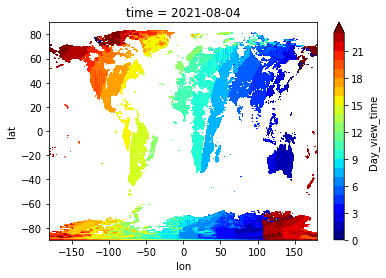

In [5]:
FILE_NAME = '/media/ck/LStorage/MODIS_LST/terra/MOD11C1.A2008068.006.2015343141238.hdf'
test = read_modis_monthly(FILE_NAME, dnames=['Day_view_time'])   #['CMG 0.05 Deg Monthly NDVI']
((test['Day_view_time'].isel(time=0))).plot.contourf(levels=np.arange(0,24), cmap='jet')

In [26]:
night = '/media/ck/Elements/global/AMSR2/daily/25km/night/raw/LPRM-AMSR2_L3_D_SOILM3_V001_20200504011048.nc4'
day = '/media/ck/Elements/global/AMSR2/daily/25km/day/raw/LPRM-AMSR2_L3_A_SOILM3_V001_20120719000732.nc4.nc4'
def get_time(filename):
    amsr = xr.open_dataset(filename)
    times = amsr['scantime']
    times_flat = times.values.flat
    real_time = []
    real_hours = []
    for tf in times_flat:
        if np.isnat(tf):
            real_time.append("NaT")
            real_hours.append(-999)
        else:
           # ipdb.set_trace()
            real_time.append(pd.to_datetime(tf))
            real_hours.append(pd.to_datetime(tf).hour)
    real_hours = np.array(real_hours)
    real_hours.shape = times.shape
    return real_hours

In [27]:
nighttest = xr.open_dataset(night)
daytest = xr.open_dataset(day)

In [31]:
nighttest.sel(Latitude=10, Longitude=0, method='nearest').scantime

<xarray.DataArray 'scantime' ()>
array('2020-05-04T01:33:01.091192448', dtype='datetime64[ns]')
Coordinates:
    Latitude   float32 10.125
    Longitude  float32 0.125
Attributes:
    long_name:  Scan time

In [30]:
daytest.sel(Latitude=10, Longitude=0, method='nearest').scantime

<xarray.DataArray 'scantime' ()>
array('2012-07-19T13:46:47.752200448', dtype='datetime64[ns]')
Coordinates:
    Latitude   float32 10.125
    Longitude  float32 0.125
Attributes:
    long_name:  Scan time

In [8]:
nighthours = get_time(night)

In [9]:
dayhours = get_time(day)

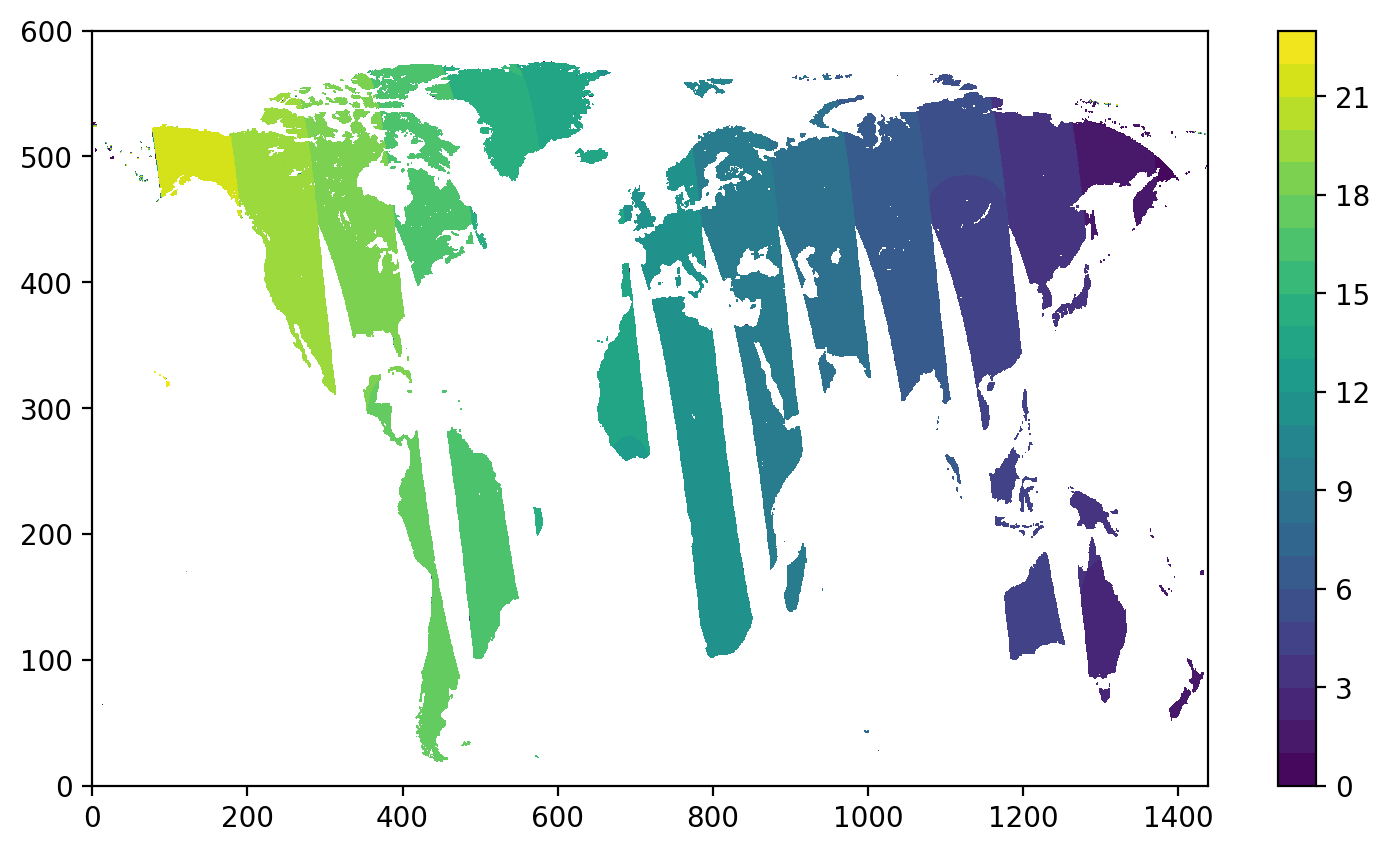

In [10]:
f = plt.figure(figsize=(9,5), dpi=200)
plt.contourf(dayhours.T[::-1,:], levels=np.arange(0,24))
plt.colorbar()
f.savefig('/media/ck/Elements/global/AMSR2/day_hours.jpg')

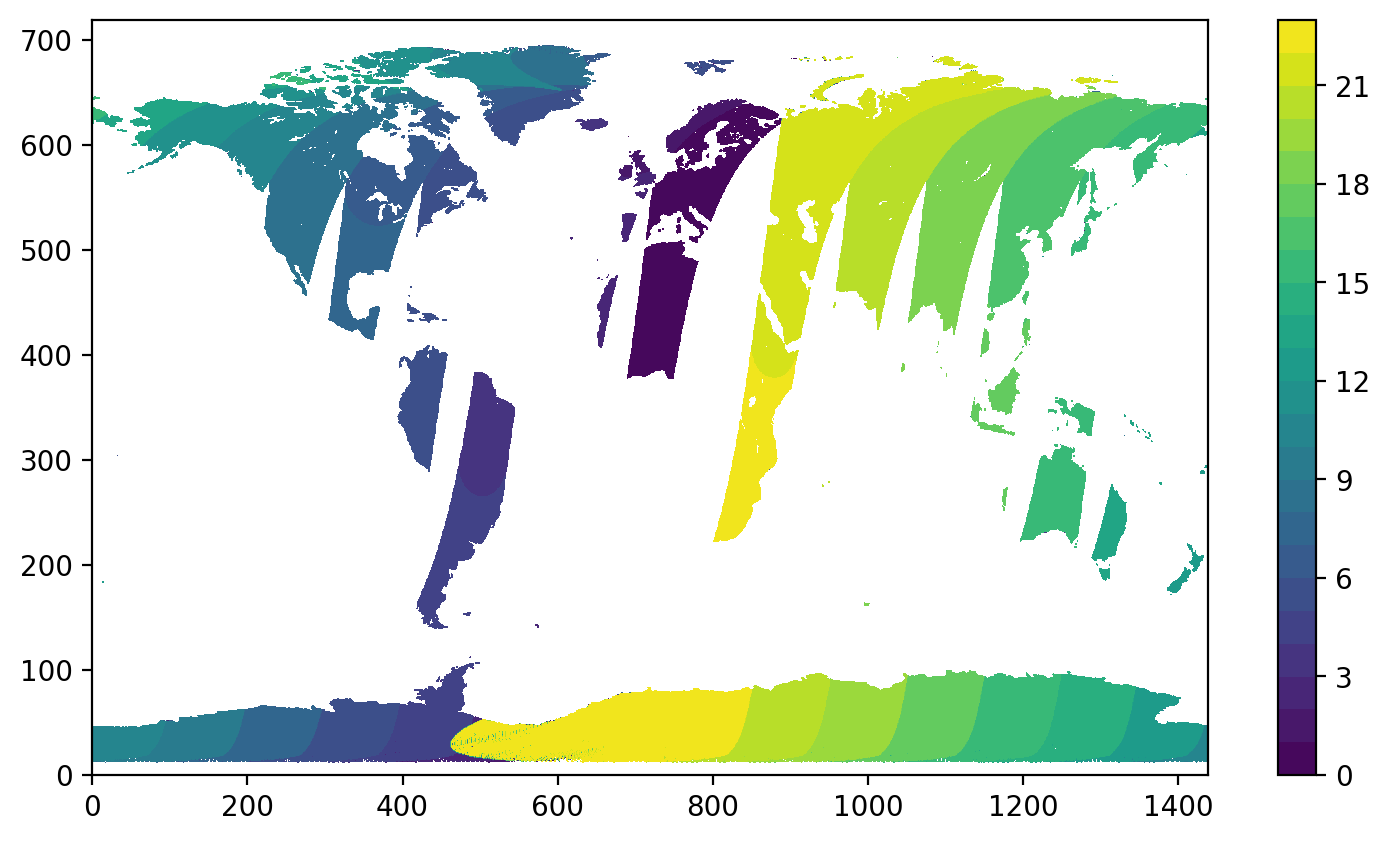

In [11]:
f = plt.figure(figsize=(9,5), dpi=200)
plt.contourf(nighthours.T[::-1,:], levels=np.arange(0,24))
plt.colorbar()
f.savefig('/media/ck/Elements/global/AMSR2/night_hours.jpg')

In [33]:
a[::-1]

array([9, 8, 7, 6, 5, 4, 3, 2, 1, 0])

In [32]:
test1 = xr.open_dataset('/media/ck/Elements/global/AMSR2/daily/25km/day_anom/amsr2_25km_anom_20200725.nc')
test2 = xr.open_dataset('/media/ck/Elements/global/AMSR2/daily/25km/night_anom/amsr2_25km_anom_20200725.nc')

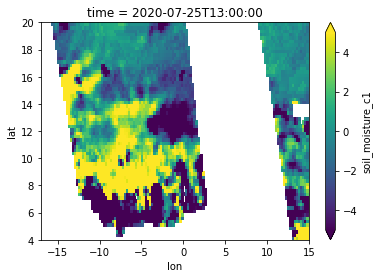

In [40]:
test1['soil_moisture_c1'].sel(lat=slice(4,20),lon=slice(-17,15)).squeeze().plot(vmin=-5, vmax=5)

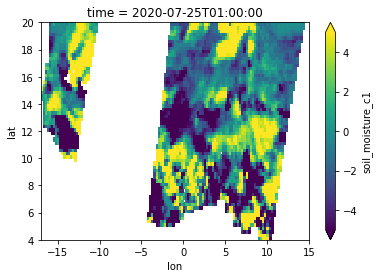

In [39]:
test2['soil_moisture_c1'].sel(lat=slice(4,20),lon=slice(-17,15)).squeeze().plot(vmin=-5, vmax=5)

In [ ]:
f = plt.figure(figsize=(9,5), dpi=200)

ax = f.add_subplot(2,1,1)
plt.contourf(nighthours.T[::-1,:], levels=np.arange(0,24))
plt.colorbar()
f.savefig('/media/ck/Elements/global/AMSR2/night_hours.jpg')